## Installing libraries

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pyreadr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 KB 33.4 MB/s eta 0:00:00


In [3]:
# instructions from here: https://colab.research.google.com/drive/1c_RGCgQeLHVXlF44LyOFjfUW32CmG6BP#scrollTo=LAZ11nESX6qt
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
!conda install jax==0.2.17 numpyro==0.7.1 -c conda-forge

Solving environment: \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - jax==0.2.17
    - numpyro==0.7.1


The following packages wil

In [2]:
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import pyreadr
import seaborn as sns
import sys
import tensorflow as tf
import PIL
import tensorflow_probability as tfp
import glob

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

import pickle

## Defining the GP priors

In [3]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()

In [4]:
args = {"input_size": 21,
        "learning_rate": 1.0e-6, 
        "batch_size": 128,
        "latent_dim": 4,
        "gp_kernel": kernel,
        "num_examples_to_generate": 4,
        "train_size": 1000,
        "test_size": 1000,
        "num_warmup": 1000,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 1
        }

In [5]:
xs = np.arange(0, 1, 1/(4*args["input_size"]))
x2ds = [np.array([i, j]) for i in xs for j in xs]
x2ds=np.asarray(x2ds)

In [6]:
tfd = tfp.distributions
gp = tfd.GaussianProcess(kernel, x2ds, always_yield_multivariate_normal=True)

In [7]:
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

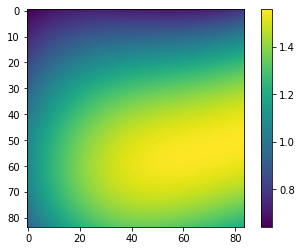

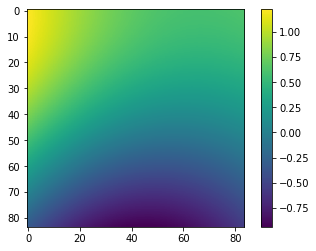

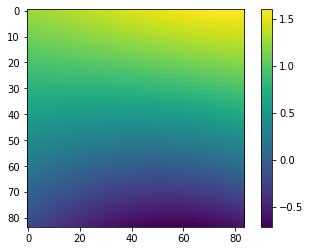

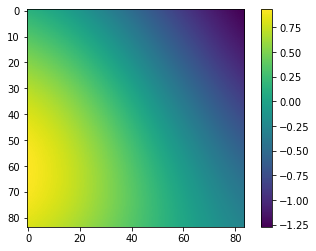

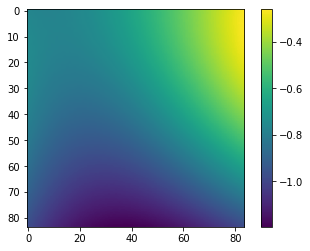

In [8]:
for i in range(5):
  sample = np.reshape(gp.sample(1), (4*args["input_size"], 4*args["input_size"]))
  heatmap2d(sample)

## Implementing the CVAE

In [107]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, inputs, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(4*inputs, 4*inputs, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=inputs*inputs*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(inputs, inputs, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [108]:
optimizer = tf.keras.optimizers.Adam(args["learning_rate"])


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [109]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[args["num_examples_to_generate"], args["latent_dim"]])
model = CVAE(args["input_size"], args["latent_dim"])

In [110]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.gca().invert_yaxis()
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [111]:
train_data = [np.reshape(gp.sample(1), (4*args["input_size"], 4*args["input_size"], 1)) for i in range(args["train_size"])]
test_data = [np.reshape(gp.sample(1), (4*args["input_size"], 4*args["input_size"], 1)) for i in range(args["test_size"])]

ResourceExhaustedError: ignored

In [80]:
train_data = np.array(train_data, dtype = np.float32)
test_data = np.array(test_data, dtype = np.float32)

In [81]:
train_data = train_data.tolist()
test_data = test_data.tolist()

In [82]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_data).shuffle(args["train_size"]).batch(args["batch_size"]))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_data).shuffle(args["test_size"]).batch(args["batch_size"]))

In [83]:
# Pick a sample of the test set for generating output images
assert args["batch_size"] >= args["num_examples_to_generate"]
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:args["num_examples_to_generate"], :, :, :]

In [89]:
generate_and_save_images(model, 0, test_sample)
epoch = 1
eval = True
while eval==True:
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
  epoch = epoch+1
  if np.abs(elbo)<50:
    eval = False
  if elbo != elbo:
    break

Output hidden; open in https://colab.research.google.com to view.

## Generating GPCVAE priors

In [90]:
def GPCVAE_priors(test_dataset, num):
  """
  Inputs: test_dataset = set of testing samples from which we generate priors
          num = number of samples we generate
  """
  for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num, :, :, :]
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  return(predictions)

In [93]:
prior_set = GPCVAE_priors(test_dataset, 5)

In [94]:
for img in prior_set:
  img = np.reshape(img, (44, 44))

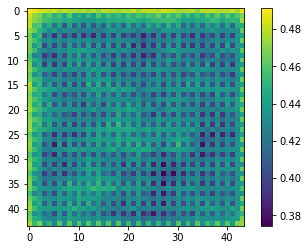

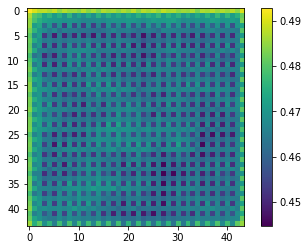

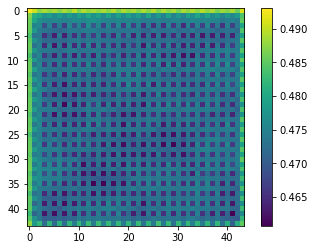

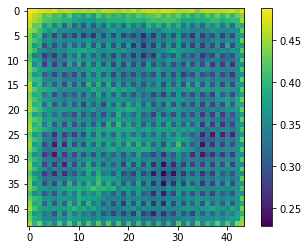

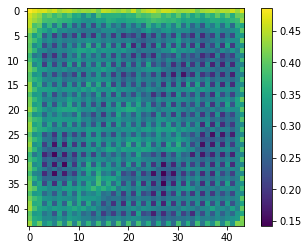

In [95]:
for img in prior_set:
  heatmap2d(img)